# Imports

In [24]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import seaborn as sns

---

# Carga de datos

In [2]:
targets_competencia = pd.read_pickle("../../../data/tp2/ref_hashes_target.pkl")

In [4]:
features_v1 = pd.read_pickle("../features/auctions_ventana_1_entrenar.pkl")
features_v2 = pd.read_pickle("../features/auctions_ventana_2_entrenar.pkl")
features_v3 = pd.read_pickle("../features/auctions_ventana_3_entrenar.pkl")
features_v4 = pd.read_pickle("../features/auctions_ventana_4_entrenar.pkl")

#Especiales
features_v1_especial = pd.read_pickle("../features/auctions_ventana_1_entrenar_especiales.pkl")
features_v2_especial = pd.read_pickle("../features/auctions_ventana_2_entrenar_especiales.pkl")
features_v3_especial = pd.read_pickle("../features/auctions_ventana_3_entrenar_especiales.pkl")

In [5]:
labels_v1 = pd.read_pickle("../../modelo/targets/targets_ventana_1_auctions.pkl")
labels_v2 = pd.read_pickle("../../modelo/targets/targets_ventana_2_auctions.pkl")
labels_v3 = pd.read_pickle("../../modelo/targets/targets_ventana_3_auctions.pkl")
labels_v4 = pd.read_pickle("../../modelo/targets/targets_ventana_4_auctions.pkl")

# Modelo

In [12]:
train = features_v1.merge(labels_v1, left_index=True, right_index=True)

In [18]:
X, y = train.iloc[:,:-1], train.iloc[:,-1]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.33, random_state=123)

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

space = {
        'n_estimators': hp.choice('n_estimators', np.arange(100, 500+1)),
        'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
        'max_depth':  hp.choice('max_depth', np.arange(1, 9, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 0.5, 6, 1),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'eval_metric': 'rmse',
        'obj': 'reg:squarederror',
        'nthread': 6,
        'booster': 'gbtree',
        'tree_method': 'exact',
        'silent': 1,
        'seed': 123
}


def objective(space):
    model = xgb.train(space, dtrain,evals=[(dtest, "test")], verbose_eval=False)
    pred = model.predict(dtest)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    #print("RMSE: {}".format(rmsee)) 

    return{'loss':rmse, 'status': STATUS_OK }


trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print(best)

100%|██████████| 100/100 [01:37<00:00,  1.17it/s, best loss: 88460.38893331273]
{'colsample_bytree': 0.75, 'eta': 0.375, 'gamma': 0.8500000000000001, 'max_depth': 5, 'min_child_weight': 1.0, 'n_estimators': 44}


# Que pasa si armo un modelo con datos uniformes

In [20]:
train_v1 = features_v1.merge(labels_v1, left_index=True, right_index=True)

In [21]:
train_v2 = features_v1.merge(labels_v2, left_index=True, right_index=True)

In [22]:
train_v3 = features_v1.merge(labels_v3, left_index=True, right_index=True)

In [23]:
train_v4 = features_v1.merge(labels_v4, left_index=True, right_index=True)

### Nos quedamos con train_v4 que es el mas reciente, y le agregamos datos de las ventanas anteriores

In [38]:
train_uniforme = train_v4.append(train_v3.loc[(train_v3["target"] > 25920) & (train_v3["target"] < 233280)])

In [39]:
train_uniforme = train_uniforme.append(train_v2.loc[(train_v3["target"] > 25920) & (train_v2["target"] < 233280)])

In [40]:
train_uniforme = train_uniforme.append(train_v1.loc[(train_v3["target"] > 25920) & (train_v1["target"] < 233280)])

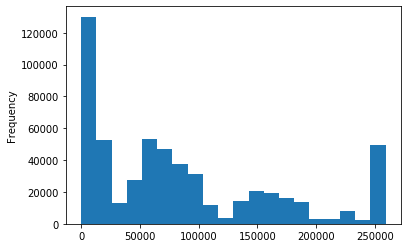

In [41]:
train_uniforme["target"].plot(kind="hist", bins=20)

In [60]:
X, y = train_uniforme.iloc[:,:-1], train_uniforme.iloc[:,-1]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.33, random_state=123)

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

space = {
        'n_estimators': hp.choice('n_estimators', np.arange(100, 500+1)),
        'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
        'max_depth':  hp.choice('max_depth', np.arange(1, 9, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 0.5, 6, 1),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'eval_metric': 'rmse',
        'objective': 'reg:linear',
        'nthread': 6,
        'silent': 1,
        'seed': 123
}


def objective(space):
    model = xgb.train(space, dtrain,evals=[(dtest, "test")], verbose_eval=False)
    pred = model.predict(dtest)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    #print("RMSE: {}".format(rmsee)) 

    return{'loss':rmse, 'status': STATUS_OK }


trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print(best)
#100%|██████████| 100/100 [02:39<00:00,  1.28s/it, best loss: 76914.3391598095]
#{'colsample_bytree': 0.9, 'eta': 0.4, 'gamma': 0.55, 'max_depth': 4, 'min_child_weight': 2.0, 'n_estimators': 260}b

100%|██████████| 100/100 [02:30<00:00,  1.41s/it, best loss: 76915.63261071371]
{'colsample_bytree': 0.75, 'eta': 0.45, 'gamma': 0.6000000000000001, 'max_depth': 4, 'min_child_weight': 5.0, 'n_estimators': 120}


In [73]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

X, y = train_uniforme.iloc[:,:-1], train_uniforme.iloc[:,-1]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.33, random_state=123)

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

#model = xgb.train(space, dtrain,evals=[(dtest, "test")], verbose_eval=False)


cross = xgb.cv({'colsample_bytree': 0.9, 'eta': 0.4, 'gamma': 0.55, 'max_depth': 4, 'min_child_weight': 2.0, 'n_estimators': 260, 'silent' : 1}, dtrain, 5000, nfold=10, early_stopping_rounds=20, verbose_eval=1)

[0]	train-rmse:93704.8+25.5939	test-rmse:93720.5+314
[1]	train-rmse:83591.7+54.9959	test-rmse:83626.1+277.691
[2]	train-rmse:79511.3+45.4497	test-rmse:79566.3+232.713
[3]	train-rmse:77935.7+27.3626	test-rmse:78004.1+210.95
[4]	train-rmse:77322.4+23.8933	test-rmse:77400.5+202.94
[5]	train-rmse:77076.2+23.0776	test-rmse:77166.7+199.68
[6]	train-rmse:76964.1+22.5129	test-rmse:77066.1+196.728
[7]	train-rmse:76907.6+22.5746	test-rmse:77018+197.455
[8]	train-rmse:76870.4+21.2309	test-rmse:76989.6+196.311
[9]	train-rmse:76841+20.0653	test-rmse:76971.3+197.487
[10]	train-rmse:76817.8+20.3018	test-rmse:76957.2+196.584
[11]	train-rmse:76800.2+20.1705	test-rmse:76950.9+196.725
[12]	train-rmse:76782.7+19.74	test-rmse:76942.1+195.655
[13]	train-rmse:76765.7+19.9961	test-rmse:76933+194.664
[14]	train-rmse:76751.2+20.2278	test-rmse:76928.8+194.555
[15]	train-rmse:76738+20.5251	test-rmse:76924.2+193.592
[16]	train-rmse:76726.8+21.3959	test-rmse:76924.8+191.047
[17]	train-rmse:76713.8+21.975	test-rmse:

In [74]:
cross.mean()

train-rmse-mean    78071.483807
train-rmse-std        24.246825
test-rmse-mean     78213.746271
test-rmse-std        207.770242
dtype: float64

# Qué tan bien funciona el modelo para predecir losdatos que no están en los utlimos tres dias

In [48]:
train_6_dias = features_v1_especial.merge(labels_v4, left_index=True, right_index=True)

In [50]:
X, y = train_6_dias.iloc[:,:-1], train_6_dias.iloc[:,-1]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.33, random_state=123)

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

space = {
        'n_estimators': hp.choice('n_estimators', np.arange(100, 500+1)),
        'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
        'max_depth':  hp.choice('max_depth', np.arange(1, 9, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 0.5, 6, 1),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'eval_metric': 'rmse',
        'obj': 'reg:squarederror',
        'nthread': 6,
        'booster': 'gbtree',
        'tree_method': 'exact',
        'silent': 1,
        'seed': 123
}


def objective(space):
    model = xgb.train(space, dtrain,evals=[(dtest, "test")], verbose_eval=False)
    pred = model.predict(dtest)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    #print("RMSE: {}".format(rmsee)) 

    return{'loss':rmse, 'status': STATUS_OK }


trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print(best)
#100%|██████████| 100/100 [02:39<00:00,  1.28s/it, best loss: 76914.3391598095]
#{'colsample_bytree': 0.9, 'eta': 0.4, 'gamma': 0.55, 'max_depth': 4, 'min_child_weight': 2.0, 'n_estimators': 260}b

100%|██████████| 100/100 [00:10<00:00,  9.12it/s, best loss: 253.171875]
{'colsample_bytree': 0.75, 'eta': 0.5, 'gamma': 0.9, 'max_depth': 0, 'min_child_weight': 4.0, 'n_estimators': 243}


### Tiene sentido, si por definición TODOS los labels son 259200... Capaz un feature de censoring ayude

---

---

---

# LO QUE SIGUE ACA DEBAJO; ES VIEJO

# Miro coincidencias para las ventanas

In [5]:
i = 1
for ventana in ventanas:
    coincidencias = pd.Series(targets_competencia.index.isin(ventana.index)).value_counts()
    porcentaje = round(100*coincidencias[True] / (coincidencias[True] + coincidencias[False]), 2)
    print("El {}% de los dispositivos de la competencia están en la ventana {}".format(porcentaje, i))
    i += 1

El 68.0% de los dispositivos de la competencia están en la ventana 1
El 69.63% de los dispositivos de la competencia están en la ventana 2
El 73.22% de los dispositivos de la competencia están en la ventana 3
El 75.15% de los dispositivos de la competencia están en la ventana 4


---

# Para cada dispositivo, veo en qué ventanas aparece

In [8]:
apariciones = targets_competencia.copy()

In [9]:
for ventana_nro in range(1,5):
    apariciones["en_ventana_{}".format(ventana_nro)] = targets_competencia.index.isin(ventanas[ventana_nro - 1].index)

In [10]:
apariciones["OR"] = (apariciones["en_ventana_1"] | apariciones["en_ventana_2"] | apariciones["en_ventana_3"] | apariciones["en_ventana_4"])

In [11]:
apariciones["OR"].value_counts()

True     3492
False     545
Name: OR, dtype: int64

---

## Conclusion: Como al parecer usar features de varios datasets mejora considerablemente la puntuación, voy a tratar de crear features para personas "similares" a las de la competencia. Esto es, crear features sólo con los dispositivos de la competencia y aquellos otros que tengan la misma presencia en los datos (que se puedan calcular los mismos features)

---

# Entreno hasta la ventana 4 que es la ultima que esta completa

## Tiempo medio todas las ventanas

In [11]:
targets_competencia.index.rename("device_id", inplace=True)

In [12]:
gb = auctions_competencia.groupby("device_id")
ps = {}
for t, g in gb:
    ps[t] = g["date"].sub(g["date"].shift()).mean()
targets_competencia["tiempo_medio_entre_apariciones_todas_las_ventanas"] = pd.Series(ps).dt.total_seconds().to_frame().rename(columns={0: "tiempo_medio_entre_apariciones_todas_las_ventanas"})

---

# Random search

In [55]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
X, y = train.iloc[:,:-1], train.iloc[:,-1]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=123)

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

space = {
        'n_estimators': hp.choice('n_estimators', np.arange(100, 1000+1)),
        'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
        # A problem with max_depth casted to float instead of int with
        # the hp.quniform method.
        'max_depth':  hp.choice('max_depth', np.arange(1, 7, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'eval_metric': 'rmse',
        'objective': 'reg:linear',
        # Increase this number if you have more cores. Otherwise, remove it and it will default 
        # to the maxium number. 
        'nthread': 6,
        'booster': 'gbtree',
        'tree_method': 'exact',
        'silent': 1,
        'seed': 123
}


def objective(space):
    model = xgb.train(space, dtrain,evals=[(dtest, "test")], verbose_eval=False)
    pred = model.predict(dtest)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    #print("RMSE: {}".format(rmsee)) 

    return{'loss':rmse, 'status': STATUS_OK }


trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print(best)
#100%|██████████| 1000/1000 [02:47<00:00,  4.30it/s, best loss: 55400.115263399275]
#{'colsample_bytree': 0.8, 'eta': 0.45, 'gamma': 0.9500000000000001, 'max_depth': 2, 'min_child_weight': 4.0, 'n_estimators': 86, 'subsample': 0.7000000000000001}

100%|██████████| 100/100 [01:07<00:00,  1.46it/s, best loss: 88256.51073621812]
{'colsample_bytree': 0.8500000000000001, 'eta': 0.47500000000000003, 'gamma': 0.65, 'max_depth': 5, 'min_child_weight': 6.0, 'n_estimators': 725}


---

# Nuevas pruebas, modelo de ventana individual

In [73]:
labels_v1 = pd.read_pickle("../../modelo/targets/targets_ventana_1_auctions.pkl")
labels_v2 = pd.read_pickle("../../modelo/targets/targets_ventana_2_auctions.pkl")
labels_v3 = pd.read_pickle("../../modelo/targets/targets_ventana_3_auctions.pkl")
labels_v4 = pd.read_pickle("../../modelo/targets/targets_ventana_4_auctions.pkl")

In [74]:
features = [features_v1, features_v2, features_v3, features_v4]
labels = [labels_v1, labels_v2, labels_v3, labels_v4]

In [75]:
modelos = []
for x in range(4):
    train = features[x].merge(labels[x], left_index=True, right_index=True, how="left")
    #train["target"] = train["target"].fillna(259200)
    X, y = train.iloc[:,:-1], train.iloc[:,-1]
    X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.05, random_state=123)
    xg_reg = xgb.XGBRegressor(n_jobs=6)
    xg_reg.fit(X_train,y_train)
    preds = xg_reg.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print("RMSE v_{}: {}".format(x+1, rmse))
    modelos.append(xg_reg)
    

RMSE v_1: 88721.93541314879
RMSE v_2: 90725.26771286836
RMSE v_3: 89430.53749500832
RMSE v_4: 88293.96164069342


# Cargo features de competencia

In [79]:
features_v1_competencia = pd.read_pickle("../features/auctions_train_ventana_1_competencia.pkl")
features_v2_competencia = pd.read_pickle("../features/auctions_train_ventana_2_competencia.pkl")
features_v3_competencia = pd.read_pickle("../features/auctions_train_ventana_3_competencia.pkl")
features_v4_competencia = pd.read_pickle("../features/auctions_train_ventana_4_competencia.pkl")

In [102]:
targets_competencia = pd.read_pickle("../../../data/tp2/ref_hashes_target.pkl")

In [110]:
demo = targets_competencia.merge(features_v1_competencia, left_index=True, right_index=True)

In [111]:
labels_v4_competencia_posta = targets_competencia.merge(labels_v4, left_index=True, right_index=True)

In [114]:
train_inner = demo.merge(labels_v4_competencia_posta, how="inner", left_index=True, right_index=True)